In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from hw2 import get_mnist_threes_nines, display_image
%matplotlib inline

In [1]:
from network import NeuralNetwork

In [3]:
nn = NeuralNetwork(layer_dimensions=[784,200,1], activations=["relu", "sigmoid"], loss_fn="cross-entropy")

In [5]:
nn.train()

TypeError: train() missing 2 required positional arguments: 'X' and 'y'

# CS189 / 289A: Introduction to Machine Learning
## Homework 2: Neural Networks
---

**Collaborators:** Matthew Dworkin, Brian Huckleberry

**Resources:** https://stats.stackexchange.com/questions/333394/what-is-the-derivative-of-the-relu-activation-function, https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795

**Statement:** *I certify that all solutions are entirely in my own words and that I ahve not looked at another student's solutions. I have given credit to all external sources I consulted.*

**Signature:** William Furtado

### Part 1.1: Getting Started

In [2]:
(X_train, y_train), (X_test, y_test) = get_mnist_threes_nines()
ex_nine, ex_three = X_train[:2]

Nine Label: 1
Image Dimensions: (28, 28)


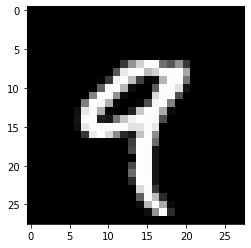

In [3]:
display_image(ex_nine)
print(f"Nine Label: {y_train[0]}")
print(f"Image Dimensions: {ex_nine.shape}")

Three Label: 0
Image Dimensions: (28, 28)


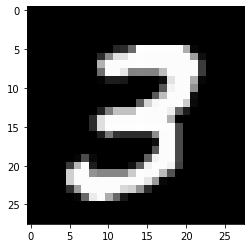

In [4]:
display_image(ex_three)
print(f"Three Label: {y_train[1]}")
print(f"Image Dimensions: {ex_three.shape}")

### Part 1.2: Implementing the Neural Network

**Part 1.2 (a)**: Finite differences checker, used to help implement `my_nn_finite_difference_checker` in 1.3a. Feel free to modify the function signature, or to skip this part and implement `my_nn_finite_difference_checker` without this helper function.

In [5]:
def finite_difference_checker(f, x, k, eps=10e-5):
    """Returns \frac{\partial f}{\partial x_k}(x)"""
    mask = np.zeros(len(x))
    mask[k] = eps
    return (f(x + mask) - f(x - mask)) / (2 * eps)

**Part 1.2 (b):** Functions that implement neural network layers.

In [6]:
# Part 1.2bi
def stable_sigmoid(x):
    out_arr_pos, out_arr_neg = np.zeros(x.shape), np.zeros(x.shape)
    
    np.exp(-x, where=x>=0, out=out_arr_pos)
    out_arr_pos = 1. / (1. + out_arr_pos)
    out_arr_pos = np.where(out_arr_pos == 1., 0, out_arr_pos)
    
    np.exp(x, where=x<0, out=out_arr_neg)
    
    out_arr_neg = out_arr_neg / (1. + out_arr_neg)
    
    return out_arr_pos + out_arr_neg


def sigmoid_activation(x, eps=10e-15):
    out = stable_sigmoid(x)
    grad = stable_sigmoid(x) * (1. - stable_sigmoid(x))
    return np.clip(out, a_min=eps, a_max=1-eps), grad

In [7]:
# Part 1.2bii
def logistic_loss(g, y):
    """
    Computes the loss and gradient for binary classification with logistic
    loss

    Inputs:
    - g: Output of final layer with sigmoid activation,
         of shape (n, 1) 

    - y: Vector of labels, of shape (n,) where y[i] is the label for x[i] 
         and y[i] in {0, 1}

    Returns a tuple of:
    - loss: array of losses
    - dL_dg: Gradient of the loss with respect to g
    """
    y = y.reshape(g.shape)
    loss = - np.log((g ** y) * ((1 - g) ** (1 - y)))
    dL_dg = ((1 - y) / (1 - g)) - (y / g)
    
    assert loss.shape == g.shape
    assert loss.shape == y.shape
    
    return loss, dL_dg

In [8]:
# Part 1.2biii
def relu_activation(s):
    out = s * (s > 0)
    ds = 1.  * (s > 0)
    
    assert out.shape == s.shape
    assert ds.shape == s.shape
    
    return out, ds

In [9]:
# Part 1.2biv
def layer_forward(x, W, b, activation_fn):
    out, grad_act_fn = activation_fn(x @ W + b)
    cache = dict(x=x, W=W, b=b, grad_act_fn=grad_act_fn)
    return out, cache

**Part 1.2 (c)**: In this part you will code functions that initialize the neural network's weights. You will also code the forward pass which ties everything together, computing the output of a neural network with weights given by `weight_matrices` + `biases`, activation functions given by `activations`, on the input `X_batch`, a 2d input where each row is an individual input vector.

In [10]:
def create_weight_matrices(layer_dims):
    """
    Creates a list of weight matrices defining the weights of NN
    
    Inputs:
    - layer_dims: A list whose size is the number of layers. layer_dims[i] defines
      the number of neurons in the i+1 layer.

    Returns a list of weight matrices
    """
    weights = []
    num_layers = len(layer_dims) - 1
    for i in range(num_layers):
        layer_weight = np.random.normal(loc=0, scale=0.01, size=(layer_dims[i], layer_dims[i+1]))
        weights.append(layer_weight)
    return weights

def create_bias_vectors(layer_dims):
    biases = []
    num_layers = len(layer_dims) - 1
    for i in range(num_layers):
        layer_bias = np.random.normal(loc=0, scale=0.01, size=(1, layer_dims[i+1]))
        biases.append(layer_bias)
    return biases

def forward_pass(X_batch, weight_matrices, biases, activations):
    output = X_batch
    layer_caches = []
    for W, b, activation_fn in zip(weight_matrices, biases, activations):
        output, layer_cache = layer_forward(output, W, b, activation_fn)
        layer_caches.append(layer_cache)
    return output, layer_caches

**Part 1.2 (d):** Implementing the backpropogation algorithm

In [11]:
def backward_pass(dL_dg, layer_caches):
    final_layer_cache = layer_caches[-1]
    final_layer_delta = np.multiply(dL_dg, final_layer_cache["grad_act_fn"])
    
    final_layer_W = final_layer_cache["W"]
    final_layer_dW = np.mean(np.einsum("ij,ik->ikj", final_layer_delta, final_layer_cache["x"]), axis=0)
    final_layer_db = np.mean(final_layer_delta[:, None, :], axis=0)
    
    grad_Ws = [final_layer_dW]
    grad_bs = [final_layer_db]
    
    prev_delta = final_layer_delta
    prev_w = final_layer_W
    
    num_layers = len(layer_caches)
    for l in reversed(range(num_layers - 1)):
        cache_l  = layer_caches[l]
        
        curr_delta = np.multiply(cache_l["grad_act_fn"], np.einsum("ij,jk->ki", prev_w, prev_delta.T))
        curr_dW = np.mean(np.einsum("ij,ik->ikj", curr_delta, cache_l["x"]), axis=0)
        curr_db = np.mean(curr_delta[:, None, :], axis=0)
        
        grad_Ws.append(curr_dW)
        grad_bs.append(curr_db)
        
        prev_delta = curr_delta
        prev_w = cache_l["W"]
        
    grad_Ws = list(reversed(grad_Ws))
    grad_bs = list(reversed(grad_bs))
    
    return grad_Ws, grad_bs

**Part 1.2 (e):** Train your neural network on MNIST! save the training and test losses and accuracies at each iteration to use in 1.3 (e).

In [12]:
def create_epoch(X_train, y_train, batch_size=100, remainder=80):
    shuffled_idx = np.random.permutation(len(X_train))
    X_train = X_train[shuffled_idx]
    y_train = y_train[shuffled_idx]
    first_X_train, last_X_train = X_train[:-remainder, :], X_train[-remainder:, :]
    first_y_train, last_y_train = y_train[:-remainder], y_train[-remainder:]
    
    num_batches = np.ceil(first_X_train.shape[0] / batch_size)

    X_batches = np.array_split(first_X_train, num_batches) + [last_X_train]
    y_batches = np.array_split(first_y_train, num_batches) + [last_y_train]

    return X_batches, y_batches

In [13]:
(X_train, y_train), (X_test, y_test) = get_mnist_threes_nines()
X_train = X_train.reshape(12080, 784)
X_test = X_test.reshape(2019, 784)

In [14]:
# Setting up the two-layer neural network architecture and batch size

layer_dims = [784, 200, 1]
num_epochs = 5
learning_rate = 0.1

activations = [relu_activation, sigmoid_activation]
weights = create_weight_matrices(layer_dims)
biases = create_bias_vectors(layer_dims)

In [15]:
losses, test_losses, accuracies, test_accuracies = [], [], [], []

for epoch in range(1, num_epochs + 1):
    print("-"*15)
    print(f"Epoch: {epoch}")
    print("-"*15)
    X_batches, y_batches = create_epoch(X_train, y_train)
    losses_epoch, test_losses_epoch, accuracies_epoch, test_accuracies_epoch = [], [], [], []
    for X_batch, y_batch in zip(X_batches, y_batches):
        output, layer_caches = forward_pass(X_batch, weights, biases, activations)
        
        accuracy = np.mean(np.squeeze(output > 0.5) == y_batch)
        accuracies_epoch.append(accuracy)
        
        loss, dL_dg = logistic_loss(output, y_batch)
        losses_epoch.append(np.mean(loss))
        
        grad_Ws, grad_bs = backward_pass(dL_dg, layer_caches)
        weights = [W - learning_rate * grad_W for grad_W, W in zip(grad_Ws, weights)]
        biases = [b - learning_rate * grad_b for grad_b, b in zip(grad_bs, biases)]
        
        test_pred, _ = forward_pass(X_test, weights, biases, activations)
        test_loss, _ = logistic_loss(test_pred, y_test)
        test_accuracy = np.mean(np.squeeze(test_pred > 0.5) == y_test)
        
        test_losses_epoch.append(np.mean(test_loss))
        test_accuracies_epoch.append(test_accuracy)
        
    print(f"Average Training Loss: {np.mean(losses_epoch)}")
    print(f"Average Test Loss: {np.mean(test_losses_epoch)}")
    print(f"Average Training Accuracy: {np.mean(accuracies_epoch)}")
    print(f"Average Test Accuracy: {np.mean(test_accuracies_epoch)}\n")
    
    losses.extend(losses_epoch)
    test_losses.extend(test_losses_epoch)
    accuracies.extend(accuracies_epoch)
    test_accuracies.extend(test_accuracies_epoch)
        

---------------
Epoch: 1
---------------
Average Training Loss: 0.23960273344564867
Average Test Loss: 0.2205236529372749
Average Training Accuracy: 0.937809917355372
Average Test Accuracy: 0.9506383570951988

---------------
Epoch: 2
---------------
Average Training Loss: 0.07700004910108546
Average Test Loss: 0.06875102509598666
Average Training Accuracy: 0.975206611570248
Average Test Accuracy: 0.9779082190266845

---------------
Epoch: 3
---------------
Average Training Loss: 0.06382842345014995
Average Test Loss: 0.06068772961281429
Average Training Accuracy: 0.9789876033057852
Average Test Accuracy: 0.980618013172383

---------------
Epoch: 4
---------------
Average Training Loss: 0.05645957135838234
Average Test Loss: 0.05785000507979021
Average Training Accuracy: 0.9812396694214877
Average Test Accuracy: 0.980961854121384

---------------
Epoch: 5
---------------
Average Training Loss: 0.05257265854137745
Average Test Loss: 0.05579110582778388
Average Training Accuracy: 0.98378

## Part 1.3: Deliverables
**Part 1.3a:** Deliverable which has you compute the gradient w.r.t. `weight_matrices` and `biases` using a finite differences checker

In [16]:
def finite_difference_checker(f, x, k, eps=10e-5):
    """Returns \frac{\partial f}{\partial x_k}(x)"""
    mask = np.zeros(len(x))
    mask[k] = eps
    return (f(x + mask) - f(x - mask)) / (2 * eps)

In [17]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)

def my_nn_finite_difference_checker(X_batch, y_batch, weight_matrices, biases, activations, eps=10e-5):
    grad_Ws, grad_bs = [], []
    
    for mat_idx in range(len(weight_matrices)):
        W = weight_matrices[mat_idx]
        grad_W = np.zeros(W.shape)
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                mask = np.zeros(W.shape)
                mask[i][j] = eps
                
                plus_matrices = weight_matrices[:mat_idx] + [W + mask] + weight_matrices[mat_idx + 1:]
                minus_matrices = weight_matrices[:mat_idx] + [W - mask] + weight_matrices[mat_idx + 1:]
                
                output_plus, _ = forward_pass(X_batch, plus_matrices, biases, activations)
                output_minus, _ = forward_pass(X_batch, minus_matrices, biases, activations)
                
                grad_W[i][j] = np.mean(
                    (logistic_loss(output_plus, y_batch)[0] - logistic_loss(output_minus, y_batch)[0]) / (2 * eps)
                )
                
        grad_Ws.append(grad_W)
        
    for b_idx in range(len(biases)):
        b = biases[b_idx]
        grad_b = np.zeros(b.shape)
        for j in range(b.shape[1]):
            mask = np.zeros(b.shape)
            mask[0][j] = eps
            
            plus_biases = biases[:b_idx] + [b + mask] + biases[b_idx + 1:]
            minus_biases = biases[:b_idx] + [b - mask] + biases[b_idx + 1:]
            
            output_plus, _ = forward_pass(X_batch, weight_matrices, plus_biases, activations)
            output_minus, _ = forward_pass(X_batch, weight_matrices, minus_biases, activations)
            
            grad_b[0][j] = np.mean(
                    (logistic_loss(output_plus, y_batch)[0] - logistic_loss(output_minus, y_batch)[0]) / (2 * eps)
                )
        
        grad_bs.append(grad_b)
        
    return grad_Ws, grad_bs

grad_Ws, grad_bs = my_nn_finite_difference_checker(X_batch, 
                                                   y_batch, 
                                                   weight_matrices, 
                                                   biases, 
                                                   activations)   

with np.printoptions(precision=2):
    print(grad_Ws[0])
    print()
    print(grad_Ws[1])
    print()
    print(grad_bs[0])
    print()
    print(grad_bs[1])

[[ 4.12e-04  3.34e-05]
 [-6.56e-05  2.07e-05]
 [-1.24e-03  8.02e-05]
 [ 2.26e-04 -1.41e-06]]

[[-0.  ]
 [-0.01]]

[[-0.  0.]]

[[-0.5]]


**Part 1.3b i, ii:** Deliverables for the sigmoid activation

In [18]:
# 1.3b i
s = np.asarray([1., 0., -1])
out, grad = sigmoid_activation(s)
with np.printoptions(precision=2):
    print(out)
    print(grad)
    
print("="*80)

# 1.3b ii
s = np.asarray([-1000., 1000.])
out, grad = sigmoid_activation(s)
print(out)
print(grad)

[0.73 0.5  0.27]
[0.2  0.25 0.2 ]
[1.e-14 1.e-14]
[0. 0.]


**Part 1.3b iii:** What is the derivative of the negative log-likelihood loss with respect to $g$?

$\frac{\partial{L}}{\partial{g}} = \frac{(1-y)}{(1-g)} - \frac{y}{g}$, where $y$ consists of the true labels. In code, we can represent this as: `dL_dg = ((1 - y) / (1 - g)) - (y / g)`

**Part 1.3b iv:** Explain what is returned in `cache` in your `layer_forward` implementation. (Trying to answer this question before completing your implementation might help think about should go in `cache`, which should be stuff computed during the forward pass that is needed for backpropagation in the backward pass. Just make sure your final answer pertains to what you ultimately return in `cache`.)

**Answer:** `cache` is a dictionary containing $x$, $W$ and $b$ at the current network layer and the gradient of the activation function `grad_act_fn` (i.e. sigmoid or ReLU) with respect to its inputs. Since we know that $\frac{\partial (xW+b)}{\partial W} = x$, $\frac{\partial (xW+b)}{\partial x} = W$, $\frac{\partial (xW+b)}{\partial b} = 1$ and we can directly compute $\Phi '$ from the gradient of the activation function, we have all that we need to compute $\frac{\partial l(W,b)}{\partial W_{ij}}$ and $\frac{\partial l(W,b)}{\partial b_{j}}$.

**Part 1.3c:** Deliverable which has you run a forward pass of your neural network and compute its logistic loss on some output

In [19]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)

activations = [relu_activation, sigmoid_activation]
output, _ = forward_pass(X_batch, weight_matrices, biases,activations)
loss, dL_dg = logistic_loss(output, y_batch)
print(loss.mean())

0.6985168038536878


**Part 1.3d:** Test your backward pass! compare it with 1.3a, the gradient computed by the finite difference checker. The answers should match!

In [20]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)

activations = [relu_activation, sigmoid_activation]
output, layer_caches = forward_pass(X_batch, weight_matrices, biases, activations)
loss, dL_dg = logistic_loss(output, y_batch)

grad_Ws, grad_bs = backward_pass(dL_dg, layer_caches)

with np.printoptions(precision=2):
    print(grad_Ws[0])
    print()
    print(grad_Ws[1])
    print()
    print(grad_bs[0])
    print()
    print(grad_bs[1])

[[ 4.12e-04  3.34e-05]
 [-6.56e-05  2.07e-05]
 [-1.24e-03  8.02e-05]
 [ 2.26e-04 -1.41e-06]]

[[-0.  ]
 [-0.01]]

[[-0.  0.]]

[[-0.5]]


**Part 1.3e:** Code answers for i, ii, iii

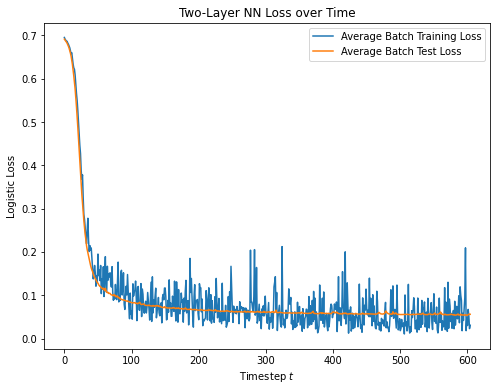

In [21]:
# Part 1.3: Plot the train and test losses from the MNIST network with step size = 0.1
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(len(losses)), losses, label="Average Batch Training Loss");
ax.plot(range(len(test_losses)), test_losses, label="Average Batch Test Loss");
ax.set_xlabel("Timestep $t$")
ax.set_ylabel("Logistic Loss")
plt.title("Two-Layer NN Loss over Time")
plt.legend();

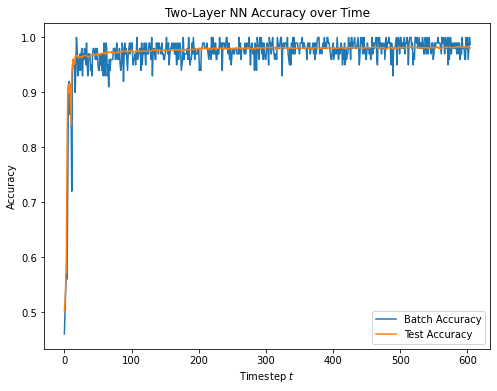

In [22]:
# Part 1.3ii: Plot the train and test accuracies from the MNIST network with step size = 0.1
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(len(accuracies)), accuracies, label="Batch Accuracy");
ax.plot(range(len(test_accuracies)), test_accuracies, label="Test Accuracy");
ax.set_xlabel("Timestep $t$")
ax.set_ylabel("Accuracy")
plt.title("Two-Layer NN Accuracy over Time")
plt.legend();

**Part 1.3iii:** Visualize (plot) some images that are misclassified by your network

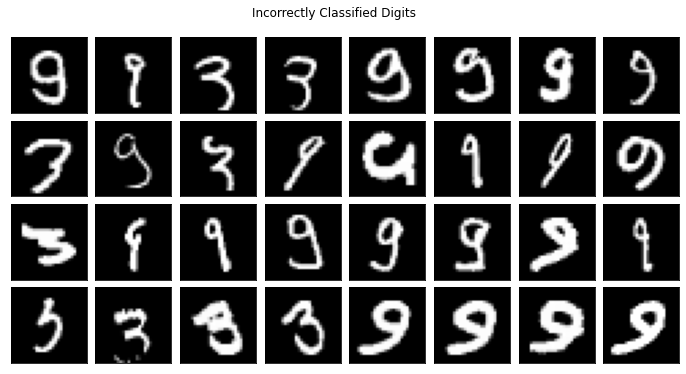

In [23]:
num_incorrect_images = 32
correct_idx = np.squeeze(test_pred > 0.5) == y_test
incorrect_images = X_test[~correct_idx][:num_incorrect_images].reshape(num_incorrect_images, 28, 28)

fig, axes = plt.subplots(4, 8, figsize=(12,6))
for ax, image, in zip(axes.flatten(), incorrect_images):
    ax.imshow(image, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.suptitle("Incorrectly Classified Digits", y=0.95);

**Part 1.3e iii:** Examine the images that your network guesses incorrectly, and explain at a high level what patterns you see in those images.

Our network misclassifies digits that are ambiguously either a *nine* or a *three*. For many of the misclassified images, they share characteristics of a *nine* and a *three* which makes them difficult to predict a single class for. In terms of the output from our network, these images have an output close to 0.5 (our threshold). Even for a human, it is difficult to tell what these images correspond to.

**Part 1.3e iv:** Rerun the neural network training but now increase the step size to 10.0. What happens? You do not need to include plots here.

As shown below, if we use a learning rate $\alpha=10.0$ we will only achieve a test accuracy of 50% and a test accuracy of 50% (i.e. the model will not converge to 100% training accuracy). The model performs much worse than if we use a learning rate of $\alpha=0.1$ as before.

In [24]:
(X_train, y_train), (X_test, y_test) = get_mnist_threes_nines()
X_train = X_train.reshape(12080, 784)
X_test = X_test.reshape(2019, 784)

In [25]:
# Setting up the two-layer neural network architecture and batch size

layer_dims = [784, 200, 1]
num_epochs = 5
learning_rate = 10.0

activations = [relu_activation, sigmoid_activation]
weights = create_weight_matrices(layer_dims)
biases = create_bias_vectors(layer_dims)

In [26]:
losses, test_losses, accuracies, test_accuracies = [], [], [], []

for epoch in range(1, num_epochs + 1):
    print("-"*15)
    print(f"Epoch: {epoch}")
    print("-"*15)
    X_batches, y_batches = create_epoch(X_train, y_train)
    losses_epoch, test_losses_epoch, accuracies_epoch, test_accuracies_epoch = [], [], [], []
    for X_batch, y_batch in zip(X_batches, y_batches):
        output, layer_caches = forward_pass(X_batch, weights, biases, activations)
        
        accuracy = np.mean(np.squeeze(output > 0.5) == y_batch)
        accuracies_epoch.append(accuracy)
        
        loss, dL_dg = logistic_loss(output, y_batch)
        losses_epoch.append(np.mean(loss))
        
        grad_Ws, grad_bs = backward_pass(dL_dg, layer_caches)
        weights = [W - learning_rate * grad_W for grad_W, W in zip(grad_Ws, weights)]
        biases = [b - learning_rate * grad_b for grad_b, b in zip(grad_bs, biases)]
        
        test_pred, _ = forward_pass(X_test, weights, biases, activations)
        test_loss, _ = logistic_loss(test_pred, y_test)
        test_accuracy = np.mean(np.squeeze(test_pred > 0.5) == y_test)
        
        test_losses_epoch.append(np.mean(test_loss))
        test_accuracies_epoch.append(test_accuracy)
        
    print(f"Average Training Loss: {np.mean(losses_epoch)}")
    print(f"Average Test Loss: {np.mean(test_losses_epoch)}")
    print(f"Average Training Accuracy: {np.mean(accuracies_epoch)}")
    print(f"Average Test Accuracy: {np.mean(test_accuracies_epoch)}\n")
    
    losses.extend(losses_epoch)
    test_losses.extend(test_losses_epoch)
    accuracies.extend(accuracies_epoch)
    test_accuracies.extend(test_accuracies_epoch)
        

---------------
Epoch: 1
---------------
Average Training Loss: 15.632439923709223
Average Test Loss: 15.980302822859036
Average Training Accuracy: 0.5105578512396693
Average Test Accuracy: 0.502932881428086

---------------
Epoch: 2
---------------
Average Training Loss: 15.910750889367716
Average Test Loss: 16.144571280786877
Average Training Accuracy: 0.5052066115702479
Average Test Accuracy: 0.4982746552380484

---------------
Epoch: 3
---------------
Average Training Loss: 15.874326105162842
Average Test Loss: 16.110112443602727
Average Training Accuracy: 0.5075619834710744
Average Test Accuracy: 0.5002476473501734

---------------
Epoch: 4
---------------
Average Training Loss: 15.880320438256176
Average Test Loss: 16.110112443602727
Average Training Accuracy: 0.5073760330578512
Average Test Accuracy: 0.5002476473501734

---------------
Epoch: 5
---------------
Average Training Loss: 15.875658179183581
Average Test Loss: 16.110112443602727
Average Training Accuracy: 0.50752066115

**Part 1.3f (optional):** Train a network to fit 100 random images to the first 100 original labels! How fast can you memorize the dataset?

In [27]:
X_train = np.random.rand(100, 784)
# YOUR CODE HERE